In [25]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data.context_data import context_data_load, context_data_split

In [26]:
class Args():
    def __init__(self):
        self.wandb = False
        self.data_path = '../data/'
        self.test_size = 0.2
        self.seed = 42
        self.model = 'CatBoost'

args = Args()

In [27]:
# data load
data = context_data_load(args)
data = context_data_split(args, data)

# category

In [28]:
data['books']['category'].sample(5)

66957                          NaN
132547    ['Business & Economics']
59417         ['Crafts & Hobbies']
53211        ['Political Science']
2240                           NaN
Name: category, dtype: object

In [29]:
# 결측치 개수
data['books']['category'].isna().sum()/data['books'].shape[0]

0.4603262686367587

In [30]:
# all categories
categories = data['books']['category'].values

# parsing category infos
categories = [eval(cat)[0] for cat in categories if type(cat)!=float]
categories[:5]

['Actresses', '1940-1949', 'Medical', 'Fiction', 'History']

In [31]:
# count all categories
unique_categories, unique_categories_count = np.unique(categories, return_counts=True)

sort_index = np.argsort(unique_categories_count)[::-1]
unique_categories = unique_categories[sort_index]
unique_categories_count = unique_categories_count[sort_index]

print("unique category number:", len(unique_categories))

unique category number: 4292


In [7]:
# useless categories
useless_index = np.where(unique_categories_count < 50)[0]
print("count useless_index: ", len(useless_index))
unique_categories[useless_index][:20]

count useless_index:  4218


array(['African Americans', 'Children', 'Actors', 'Fantasy',
       'Conduct of life', 'Dogs', 'France', 'Horror tales',
       'Transportation', 'Murder', 'French fiction', 'Adultery',
       'American literature', 'Fairy tales', 'City and town life',
       'United States', 'Brothers', 'Bears', 'Canada', 'Bibles'],
      dtype='<U114')

In [8]:
# get valid category index
valid_index = np.where(unique_categories_count >= 50)[0]
print("valid categories count: ", len(valid_index))

valid categories count:  74


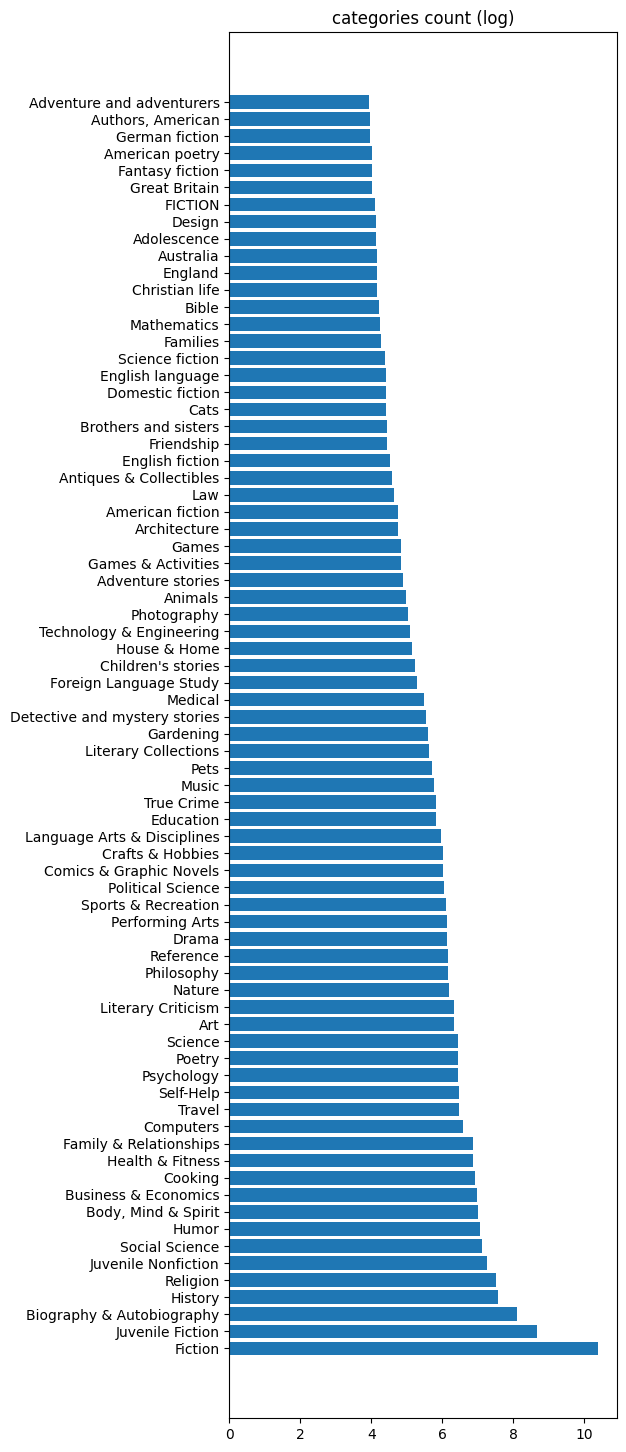

In [9]:
x, height = unique_categories[valid_index], np.log(unique_categories_count[valid_index])

plt.figure(figsize=(5,18))
plt.barh(x, height)
plt.title("categories count (log)")
plt.show()

# preprocessing

In [10]:
data['books']['category'].isna().sum()/data['books'].shape[0]

0.4603262686367587

In [11]:
# parse category
category_series = data['books']['category'].apply(lambda x: eval(x)[0] if type(x)==str else x)
category_series.isna().sum()/category_series.shape[0]

0.4603262686367587

In [32]:
# useless category name to etc
category_series = category_series.apply(lambda x: x if x in unique_categories[valid_index] else np.nan)
category_series.isna().sum()/category_series.shape[0]

0.5324062311960954

In [13]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
result = ohe.fit_transform(np.expand_dims(category_series, axis=1))

/opt/conda/envs/bookrec/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
ohe = OneHotEncoder()
data = ohe.fit_transform(np.expand_dims(category_series, axis=1))

In [15]:
from catboost import CatBoostRegressor

In [16]:
len(category_series)

149570

In [17]:
cbr = CatBoostRegressor()
y = [np.random.choice([1,2,3,4,5], 1) for _ in range(len(category_series))]
cbr.fit(data, y)

Learning rate set to 0.090324
0:	learn: 1.4146362	total: 66.3ms	remaining: 1m 6s
1:	learn: 1.4146205	total: 75.1ms	remaining: 37.5s
2:	learn: 1.4146098	total: 81.7ms	remaining: 27.1s
3:	learn: 1.4145991	total: 94.9ms	remaining: 23.6s
4:	learn: 1.4145914	total: 126ms	remaining: 25.1s
5:	learn: 1.4145861	total: 143ms	remaining: 23.7s
6:	learn: 1.4145805	total: 149ms	remaining: 21.1s
7:	learn: 1.4145725	total: 155ms	remaining: 19.2s
8:	learn: 1.4145675	total: 161ms	remaining: 17.8s
9:	learn: 1.4145586	total: 168ms	remaining: 16.6s
10:	learn: 1.4145523	total: 205ms	remaining: 18.4s
11:	learn: 1.4145459	total: 218ms	remaining: 17.9s
12:	learn: 1.4145379	total: 229ms	remaining: 17.4s
13:	learn: 1.4145308	total: 239ms	remaining: 16.9s
14:	learn: 1.4145273	total: 250ms	remaining: 16.4s
15:	learn: 1.4145225	total: 262ms	remaining: 16.1s
16:	learn: 1.4145178	total: 279ms	remaining: 16.1s
17:	learn: 1.4145151	total: 293ms	remaining: 16s
18:	learn: 1.4145085	total: 303ms	remaining: 15.7s
19:	learn

In [18]:
np.unique(np.argmax(result, axis=1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74])

In [19]:
pd.DataFrame(result, columns=ohe.get_feature_names_out())

,x0_Adolescence,x0_Adventure and adventurers,x0_Adventure stories,x0_American fiction,x0_American poetry,x0_Animals,x0_Antiques & Collectibles,x0_Architecture,x0_Art,x0_Australia,...,x0_Religion,x0_Science,x0_Science fiction,x0_Self-Help,x0_Social Science,x0_Sports & Recreation,x0_Technology & Engineering,x0_Travel,x0_True Crime,x0_etc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
149568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
